In [170]:
import os
import json
import numpy as np
import pandas as pd

In [171]:
### load title name entity tags and short hand token
IMPROT_FILE = 'validData_Reduced.csv'
ETET_GRAPHS = 'TemporalGraphData\ETETGraphs'
IMPORT_PATH = ''
START_YR, END_YR = 2009, 2022

In [172]:
### ETET network
tmp_col = []
path = os.path.join(IMPORT_PATH, ETET_GRAPHS)
for yr in range(START_YR, END_YR):
    df_tmp = pd.read_csv(os.path.join(path, 'graph_etet_{yr}.csv'.format(yr=yr)))
    tmp_col.append(df_tmp)
df_etet = pd.concat(tmp_col, axis=0)[['Focal', 'Reference', 'TargetTitle']]

In [173]:
### import title/employee id dict
with open(os.path.join(IMPORT_PATH, "title_id_dict.json"), "r") as openfile:
    org_title_2_new_id = json.load(openfile)
with open(os.path.join(IMPORT_PATH, "employee_id_dict.json"), "r") as openfile:
    org_employee_id_2_new_id = json.load(openfile)
### import golden source
df = pd.read_csv(os.path.join(IMPORT_PATH, IMPROT_FILE))
df['Start_Year'] = df['Start_Date'].apply(lambda x: int(x.split('-')[0]))
df['End_Year'] = df['End_Date'].apply(lambda x: int(x.split('-')[0]))
df.drop_duplicates(subset=['ID', 'End_Year'], keep='last', inplace=True)
df['EmployeeID'] = df.ID.apply(lambda x: org_employee_id_2_new_id[x])
df['TitleID'] = df.Title.apply(lambda x: org_title_2_new_id[x])
df.head(3)

,ID,Firm,Title,Start_Date,End_Date,Title_Group,EDU,Duration,DiversityScore,YrsOfExp,Start_Year,End_Year,EmployeeID,TitleID
0,"ACwAAA--S20BZncfI96Y51rtML5hkDoodwbFi-c,NAME_S...",Amazon,software engineer,2019-12-01,2021-10-01,software developer,"computer science, computer engineering, electr...",2,0.000000,1.0,2019,2021,E1,T1
1,"ACwAAA--zVABrailb54YsBsNL_ulhYNRVeX599Y,NAME_S...",Amazon,software engineer,2018-03-01,2019-03-01,software developer,"computer science, computer engineering, electr...",1,0.000000,0.0,2018,2019,E2,T1
2,"ACwAAA--zVABrailb54YsBsNL_ulhYNRVeX599Y,NAME_S...",JT4,technical analyst,2020-01-01,2020-07-01,it specialist,information technology,1,0.693147,1.0,2020,2020,E2,T2


In [174]:
df_ = df[['EmployeeID', 'TitleID', 'Start_Year', 'End_Year']]
df_ = df_[(df_.Start_Year >= START_YR) & (df_.End_Year < END_YR)]
tmp = df_.groupby('EmployeeID')['Start_Year'].min().reset_index()
df_ = df_.merge(tmp, on='EmployeeID', how='left').rename(columns={'Start_Year_x' : 'Start_Year', 'Start_Year_y' : 'First_Job'})
df_ = df_.sort_values(by="First_Job")


In [176]:
### peek
cur_l = 0
for yr in range(2009, 2022):
    l = len(df_[(df_.First_Job >= yr) & (df_.First_Job < yr + 1)])
    cur_l += l; print(yr, l)
gps = [(2009, 2009), (2010, 2010), (2011, 2012), (2013, 2013), (2014, 2015), (2016, 2021)]

2009 17848
2010 17096
2011 9659
2012 2930
2013 15321
2014 9781
2015 5152
2016 1909
2017 532
2018 2344
2019 1137
2020 1320
2021 344


In [107]:
df_focal_ref = df_etet.groupby('Focal')['Reference'].agg(lambda x: set(x)).reset_index()
df_focal_ref['Ref_Size'] = df_focal_ref.Reference.apply(len)
df_focal_ref.sort_values(by=['Ref_Size'])

,Focal,Reference,Ref_Size
9705,E18797,{E25484},1
25600,E6277,{E14756},1
4599,E14173,{E28302},1
27555,E8052,{E4692},1
26441,E7041,{E19408},1
...,...,...,...
2577,E1234,"{E24090, E25817, E2293, E419, E10669, E29741, ...",606
15795,E24302,"{E891, E419, E28105, E19390, E5432, E14364, E1...",607
19200,E27379,"{E23954, E419, E28105, E5432, E14364, E10669, ...",611
11499,E20419,"{E13254, E10978, E11085, E12474, E28105, E891,...",634


In [166]:
lst = df_focal_ref.Reference.values.tolist()
test_union = set().union(*lst)
len(test_union)

17309

In [168]:
test = df_focal_ref[df_focal_ref.Ref_Size >= 400] # 99 batches
print(len(test))
lst = test.Reference.values.tolist()
test_union = set().union(*lst)
len(test_union)

575


11813

In [169]:
11813/17309

0.6824773239355248

In [155]:
test = df_focal_ref[(df_focal_ref.Ref_Size <= 1)] # &(df_focal_ref.Ref_Size <= 200)
lst = test.Reference.values.tolist()
test_union = set().union(*lst)
print(len(df_focal_ref[df_focal_ref.Ref_Size <= 1]))
len(test_union)

29


25

<AxesSubplot:>

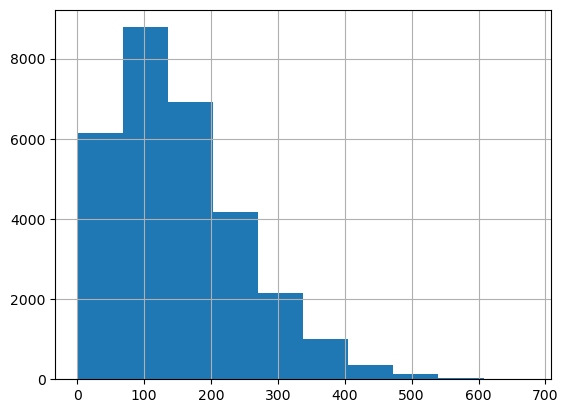

In [136]:
11813df_focal_ref.Ref_Size.hist()

In [145]:
len(df_focal_ref[df_focal_ref.Ref_Size <= 1000])

29696

In [149]:
test = df_focal_ref[(df_focal_ref.Ref_Size <= 100)] # &(df_focal_ref.Ref_Size <= 200)
lst = test.Reference.values.tolist()
test_union = set().union(*lst)
print(len(test_union))

# ### no point
# for idx, chunk in enumerate(chunks):
#     test = chunk.merge(df_focal_ref, left_on='EmployeeID', right_on='Focal', how='inner')
#     lst = test.Reference.values.tolist()
#     test_union = set().union(*lst)
#     print(len(test_union))

16502


In [150]:
### split into chunks
sub_divide = 20
cumulative_len = 0
chunks = []
for gp in gps:
    df_tmp_gp = df_[(df_.First_Job >= gp[0])&(df_.First_Job <= gp[1])]
    length = len(df_tmp_gp)
    chunks += np.array_split(df_tmp_gp, sub_divide)
    cumulative_len += length
    print(length)

{'E929',
 'E11085',
 'E7268',
 'E9918',
 'E13517',
 'E21477',
 'E24518',
 'E1773',
 'E26801',
 'E8587',
 'E16590',
 'E1396',
 'E12953',
 'E26619',
 'E3963',
 'E13632',
 'E8146',
 'E9338',
 'E15868',
 'E17106',
 'E2241',
 'E2342',
 'E19897',
 'E5626',
 'E8649',
 'E24339',
 'E19394',
 'E6369',
 'E12462',
 'E5670',
 'E24772',
 'E23543',
 'E29225',
 'E13211',
 'E15281',
 'E28053',
 'E14998',
 'E3442',
 'E13085',
 'E4244',
 'E23313',
 'E7913',
 'E9195',
 'E29813',
 'E17672',
 'E4353',
 'E319',
 'E16205',
 'E28858',
 'E25408',
 'E21719',
 'E8879',
 'E20808',
 'E3666',
 'E13639',
 'E481',
 'E19726',
 'E10702',
 'E26454',
 'E123',
 'E1308',
 'E8411',
 'E27227',
 'E19343',
 'E5574',
 'E14167',
 'E4135',
 'E22391',
 'E21085',
 'E14122',
 'E20895',
 'E9849',
 'E2696',
 'E2168',
 'E27145',
 'E1237',
 'E6039',
 'E19296',
 'E29395',
 'E26899',
 'E24254',
 'E22547',
 'E25514',
 'E7002',
 'E14342',
 'E18334',
 'E29512',
 'E21462',
 'E11129',
 'E26077',
 'E13090',
 'E15060',
 'E12304',
 'E8876',
 'E531

In [115]:
chunks[0]

,EmployeeID,TitleID,Start_Year,End_Year,First_Job
42686,E15926,T189,2013,2015,2009
33627,E12708,T45,2013,2015,2009
33626,E12708,T40,2012,2012,2009
33625,E12708,T40,2009,2011,2009
33613,E12701,T483,2018,2020,2009
...,...,...,...,...,...
34557,E13040,T110,2010,2011,2009
34556,E13040,T21,2009,2010,2009
34553,E13038,T149,2020,2020,2009
34552,E13038,T149,2019,2019,2009


In [133]:
### no point
for idx, chunk in enumerate(chunks):
    test = chunk.merge(df_focal_ref, left_on='EmployeeID', right_on='Focal', how='inner')
    lst = test.Reference.values.tolist()
    test_union = set().union(*lst)
    print(len(test_union))

10763
10862
10887
10569
10966
10555
10692
10690
10811
10747
10696
10817
10850
10760
10905
10462
10820
11175
10690
10792
11046
11263
11246
10951
11020
11239
10611
10866
11228
10827
11108
10982
11110
11026
10923
11058
10812
10552
10958
10354
10278
10620
10352
10555
10822
10322
10372
10329
10187
10380
10263
10338
10515
10631
10423
10206
10161
10253
10022
10184
10944
10999
10567
11070
10549
10900
10931
10972
10822
11136
11115
11024
11116
11022
10971
10952
11181
11291
11326
11073
10559
10929
10872
10894
10698
10954
10762
10703
10674
10704
10905
10849
10871
10161
10441
9992
10682
10651
9577
9331
7303
7531
7425
7466
7549
7023
7488
6666
7313
7399
7233
7042
6961
6372
7031
7422
6695
7180
6675
6051


In [56]:
df_peek = df_.groupby('First_Job')['EmployeeID'].count().reset_index()
df_peek.columns=['Year', 'Count']
df_peek

,Year,Count
0,2009,17848
1,2010,17096
2,2011,9659
3,2012,2930
4,2013,15321
5,2014,9781
6,2015,5152
7,2016,1909
8,2017,532
9,2018,2344


In [66]:
delta = 2
cur = START_YR
for cur in np.arange(START_YR, END_YR, delta):
    print(cur, cur + delta)
    print(len(df_[(df_.First_Job >= cur) & (df_.First_Job < cur + delta)]))
    

2009 2011
34944
2011 2013
12589
2013 2015
25102
2015 2017
7061
2017 2019
2876
2019 2021
2457
2021 2023
344


In [ ]:
delta = 2
cur = START_YR
for cur in np.arange(START_YR, END_YR, delta):
    print(cur, cur + delta)
    print(len(df_[(df_.First_Job >= cur) & (df_.First_Job < cur + delta)]))
    